# Affinity fitness landscape inference

Model writeup: https://www.overleaf.com/read/nbqgsvvstjfp

## Numerical solver

Our data includes the relaxation phase, so we solve numerically without a traveling-wave anstatz.

In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import diffrax as dx
import jax.numpy as jnp
import equinox as eqx
import numpy as np
import scipy
from pomegranate.gmm import GeneralMixtureModel
from pomegranate.distributions import Normal, DiracDelta

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import seaborn as sns

import jaxopt
import ott

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import dynamics as dyn

Phenotype discretization

In [3]:
n = 201
x = np.linspace(-3, 3, n)
zero_idx = x.tolist().index(0)

In [4]:
fitness_landscape = dyn.Sigmoid(x[0], x[-1], n, .5, 1.0, 0.)
fitness_landscape

Sigmoid(
  x0=-3.0,
  x_final=3.0,
  n=201,
  α=Array(0.5, dtype=float64, weak_type=True),
  β=Array(1., dtype=float64, weak_type=True),
  γ=Array(0., dtype=float64, weak_type=True)
)

Plot affinity-fitness response function

In [5]:
def naive_gauge(fitness_landscape_derivative, zero_idx):
    fitness_landscape = fitness_landscape_derivative.indefinite_integral()
    return fitness_landscape - fitness_landscape.vals[zero_idx]

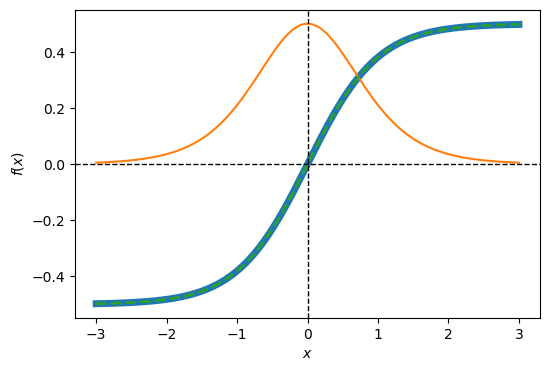

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
fitness_landscape.plot(ax, lw=5)
fitness_landscape.derivative().plot(ax)
naive_gauge(fitness_landscape.derivative(), zero_idx).plot(ax, ls="--", lw=2)
ax.axhline(0, color="k", ls="--", lw=1)
ax.axvline(0, color="k", ls="--", lw=1)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$f(x)$")
plt.show()


We fix a mutation kernel that resembles the distribution of affinity effects in the DMS data.

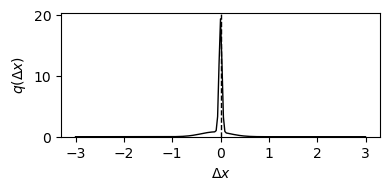

In [7]:
q = dyn.GaussianMixture(x[0], x[-1], n,
                        2.0 * jnp.array([0.7, 0.3]),
                        [0.0, -0.1],
                        [0.03, 0.3]
                        )

plt.figure(figsize=(4, 2))
q.plot(lw=1, color='k')
plt.axvline(0, color='k', ls='--', lw=1)
# plt.xlim(-1.5, 1.5)
plt.ylim(0, None)
plt.xlabel(r"$\Delta x$")
plt.ylabel(r"$q(\Delta x)$")
plt.tight_layout()
plt.show()


Initial condition $p(x, t_0) = \delta(x)$

In [8]:
# p0 = dyn.Gaussian(x[0], x[-1], n, 1.0, 0.0, 0.01)
# # p0 = p0 / p0.integral()
# assert np.allclose(p0.integral(), 1), p0.integral()

# plt.figure(figsize=(4, 2))
# p0.plot()
# plt.show()

$\theta(x, t)$ is an immigration intensity function. Typically, we want $\theta(x, t) = \theta_0\delta(x)$. To conserve probability (population size), we have emigration $\left(\int \theta(x, t) dx\right)p(x,t)$.

Alternatively, $\theta$ could specify a deterministic threshold as a function of fitness difference.

In [9]:
θ = dyn.Gaussian(x[0], x[-1], n, 0., 0.0, 0.1)

### PDE

In [10]:
@jax.jit
def term(t: float,
         p: dyn.SpatialDiscretization,
         args: tuple[dyn.AbstractSpatialDiscretization, dyn.AbstractSpatialDiscretization, float]) -> dyn.SpatialDiscretization:
    fitness_landscape, q, θ = args
    mean_f = (fitness_landscape * p).integral()
    fitness_excess = fitness_landscape - mean_f
    return fitness_excess * p + (p.convolve(q) - p * q.integral()) + θ - θ.integral() * p

### Solve

In [13]:
p0 = dyn.Gaussian(x[0], x[-1], n, 1.0, 0.0, 0.02)
# p0 = p0 / p0.integral()
t0 = 4.0

In [14]:
p0.integral()

Array(1.00030972, dtype=float64)

In [15]:
t = np.linspace(t0, 20, 81)
m = len(t)

pde_term = dyn.PDETerm(term)
rtol = 1e-7
atol = 1e-9
max_steps = 100000
dt0 = 1e-4
solver = dyn.CrankNicolson(rtol=rtol, atol=atol)
stepsize_controller = dx.PIDController(rtol=rtol, atol=atol,
                                       pcoeff=0.4, icoeff=1, dcoeff=0, dtmax=0.1
)

adjoint = dx.RecursiveCheckpointAdjoint()

@jax.jit
def p_solve(fitness_landscape, q, θ, p0, t0, t, aux=(None, None)):
    solver_state, controller_state = aux
    # convert initial condition to a dense field
    p0 *= 1.0
    sol = dx.diffeqsolve(pde_term,
                         solver,
                         adjoint=adjoint,
                         args=(fitness_landscape, q, θ),
                         t0=t0, t1=t[-1], dt0=dt0,
                         y0=p0,
                         saveat=dx.SaveAt(ts=t, solver_state=True, controller_state=True),
                         stepsize_controller=stepsize_controller,
                         max_steps=max_steps,
                         discrete_terminating_event=dx.DiscreteTerminatingEvent(lambda state, **kwargs: state.y.integral() < 0.1),
                         solver_state=solver_state,
                         controller_state=controller_state,
                         )
    eqx.error_if(sol, jnp.isinf(sol.ys.vals).any(), "inf in solution")
    return sol

p = p_solve(fitness_landscape, q, θ, p0, t0, t).ys

#### Note: how can we reuse solver state across optimization iterations?

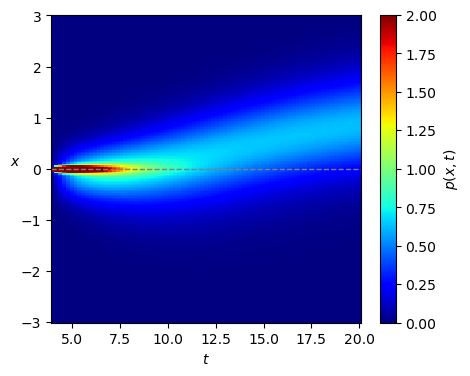

In [16]:
plt.figure(figsize=(5, 4))
p.plot(None, t, vmax=2, cmap="jet")
plt.axhline(0, color="grey", ls="--", lw=1)
plt.xlabel("$t$")
plt.ylabel("$x$", rotation=0)
plt.colorbar(label="$p(x, t)$")
plt.show()

Total mass should stay nearly constant

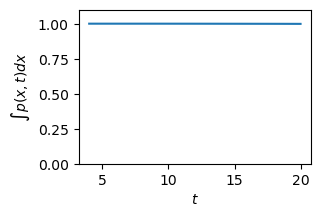

In [17]:
plt.figure(figsize=(3, 2))
plt.plot(t, p.integral())
plt.xlabel("$t$")
plt.ylabel("$\int p(x, t) dx$")
plt.ylim(0, 1.1)
plt.show()

Plot limit parameters

In [18]:
p_max = 2
x_min = -3
x_max = 3

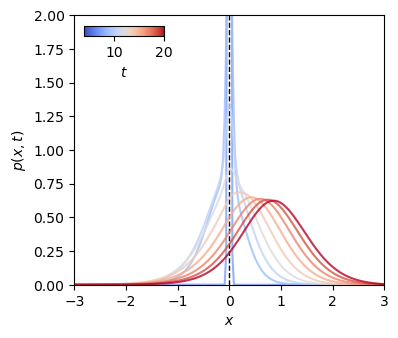

In [19]:
fig, ax = plt.subplots(figsize=(4, 3.5))
plt.axvline(0, color='k', ls='--', lw=1)
colors = plt.cm.coolwarm(t / t[-1])
for j in range(0, len(t), 10):
    ax.plot(p.x, p.vals[j],
            #  edgecolor="k",
             color=colors[j],
             alpha=0.8,#float(0.8 * (0.1 + 0.9 * 2 * abs(t[j] / t[-1] - 1 / 2))),
             )
plt.xlim(x_min, x_max)
plt.ylim(0, p_max)
plt.xlabel('$x$')
plt.ylabel('$p(x,t)$')
cbar = plt.colorbar(
             mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=t[0], vmax=t[-1]),
                                   cmap="coolwarm"),
             orientation='horizontal',
             cax=fig.add_axes([.15, 0.82, 0.2, 0.03]),
)
cbar.set_label(label='$t$', size=10)
plt.show()

Quartiles of the affinity distribution over time

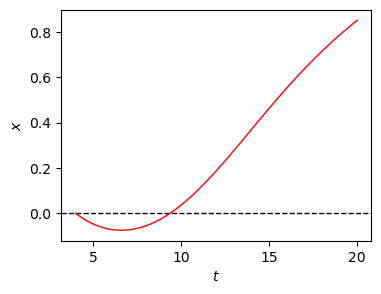

In [20]:
# # find the indices of the quartiles
# q1 = np.array([x[np.cumsum(p.vals[j], axis=0).searchsorted(0.25, side="right")] for j in range(len(t))])
# q2 = np.array([x[np.cumsum(p.vals[j], axis=0).searchsorted(0.50, side="right")] for j in range(len(t))])
# q3 = np.array([x[np.cumsum(p.vals[j], axis=0).searchsorted(0.75, side="right")] for j in range(len(t))])

fig, ax = plt.subplots(figsize=(4, 3))
plt.axhline(0, color="k", ls="--", lw=1)
# ax.fill_between(t, q1, q3, color="lightgrey")
ax.plot(t, (p * x).integral(), "r-", lw=1)
# ax.plot(t, q2, "k", lw=2)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$x$")
# ax.set_ylim(x_moment_min, x_moment_max)
plt.show()

Animation

In [21]:
fps = 24

fig, ax = plt.subplots(figsize=(6, 4))

f_x = fitness_landscape.vals

def init():
    ax.set_xlabel(r"$\Delta$ affinity")
    ax.set_ylim(1.05 * f_x[0], 1.05 * f_x[-1])
    ax.axvline(0, color='k', ls='--', lw=1)
    ax.plot(x, f_x, "grey", lw=2)

    fig.tight_layout()

def update(frame):
    for c in ax.collections:
        c.remove()
    ax.fill_between(x,
                    1.05 * (f_x[0] + (f_x[-1] - f_x[0]) * p.vals[frame, :] / p_max),
                    1.05 * f_x[0],
                    color="lightgrey",
                    facecolor=colors[frame],
                    lw=1,
                    edgecolor="k",
                    animated=True)
    ax.set_title(rf"$t = {t[frame]:.1f}$")

ani = animation.FuncAnimation(fig, update, init_func=init, frames=len(t), interval=1000/fps)

# save
ani.save("output/affinity-fitness-response/affinity-fitness-response.gif", fps=fps, dpi=200)

html_video = HTML(ani.to_jshtml())
plt.close()
html_video

MovieWriter ffmpeg unavailable; using Pillow instead.


## Sampling

In [22]:
sampling_times = np.array([5, 8, 11, 14, 17, 20], dtype=np.float64)
sample_sizes = np.array([100, 1000, 1000, 1000, 1000, 1000])
n_samples = len(sampling_times)

In [23]:
p_samples = p_solve(fitness_landscape, q, θ, p0, t0, sampling_times).ys

In [24]:
p_samples.integral()

Array([1.00031301, 1.0003187 , 1.00016814, 0.99986724, 0.99951273,
       0.99893812], dtype=float64)

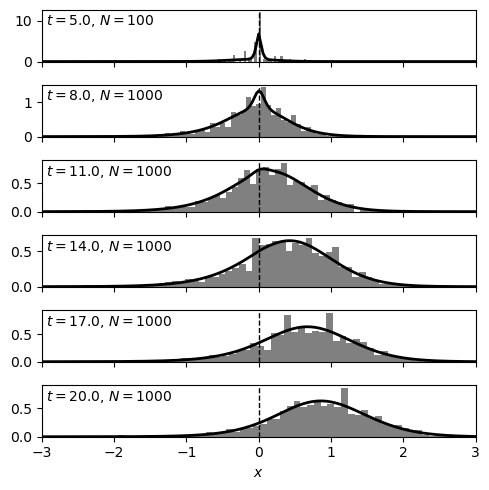

In [25]:
key = jax.random.PRNGKey(0)

fig, axes = plt.subplots(n_samples, 1, figsize=(5, 5), sharex=True)

samples = []
for sampling_time, sample_size, p_sample, ax in zip(sampling_times, sample_sizes, p_samples.vals, axes):
    samples.append([])
    for sample_idx in jax.random.choice(key, n, shape=(sample_size,), p=p_sample):
        samples[-1].append(sample_idx)
    samples[-1] = np.array(samples[-1])
    ax.axvline(0, color='k', ls='--', lw=1)
    ax.hist(x[samples[-1]], bins=50, density=True, color='grey')
    ax.plot(x, p_sample, lw=2, color='k')
    ax.annotate(rf"$t={sampling_time}$, $N={sample_size}$", xy=(0.01, 0.7), xycoords="axes fraction")
ax.set_xlabel(r"$x$")
ax.set_xlim(x_min, x_max)
plt.tight_layout()
plt.show()

## Maximum likelihood estimation

In [26]:
affinity_bin_counts = np.zeros((n_samples, n))
for i, sample in enumerate(samples):
    for j in samples[i]:
        k = np.searchsorted(x, x[j])
        affinity_bin_counts[i, k] += 1

assert all(affinity_bin_counts.sum(1) == sample_sizes)

affinity_bin_counts.shape

affinity_dists = dyn.SpatialDiscretization(x[0], x[-1], n, affinity_bin_counts)
# affinity_dists /= affinity_dists.integral()[:, None]

In [27]:
# def solve_ott(a, b, x, 𝜀):
#     geom = ott.geometry.grid.Grid([x], epsilon=𝜀)
#     ot = ott.tools.sinkhorn_divergence.sinkhorn_divergence(
#         geom,
#         x=geom.x,
#         y=geom.y,
#         static_b=True,
#     )
#     # ot_prob = ott.problems.linear.linear_problem.LinearProblem(geom, a=a, b=b)
#     # ot_solver = ott.solvers.linear.sinkhorn.Sinkhorn(
#     #     threshold=1e-3,
#     #     max_iterations=100,
#     #     norm_error=2,
#     #     lse_mode=False,
#     # )
#     # ot = ot_solver(ot_prob)
#     eqx.error_if(out, ot.converged == False, "Sinkhorn did not converge")
#     return ot.divergence

# solve_ott_vmap = jax.jit(jax.vmap(solve_ott, in_axes=(0, 0, None, None)))

In [28]:
@eqx.filter_jit
def loss(params, sampling_times, affinity_dists, zero_idx, aux):
    fitness_landscape = naive_gauge(params[0].map(jnp.exp), zero_idx)
    q = params[1].map(jnp.exp)
    sol = p_solve(fitness_landscape, q, *params[2:], sampling_times, aux)
    p = sol.ys
    eqx.error_if(p, p.x != affinity_dists.x, "Spatial discretizations do not match")
    # return affinity_dists.binop(p, jax.scipy.special.kl_div).integral().sum(), (sol.solver_state, sol.controller_state)
    return -jnp.average(jnp.log(p.vals), weights=affinity_dists.vals, axis=1).mean(), (sol.solver_state, sol.controller_state)

def Dkl(q_norm, q_ref_norm):
    return q_norm.binop(q_ref_norm, jax.scipy.special.rel_entr).integral()

# def entropy(q_norm):
#     return q_norm.map(jax.scipy.special.entr).integral()

def spline_penalty(f):
    # NOTE: maybe just ridge on derivative
    # return jax.scipy.integrate.trapezoid(f.vals**2, dx=f.δx, axis=-1)
    return jax.scipy.integrate.trapezoid((jnp.diff(f.vals, n=2, axis=-1) / f.δx**2)**2, dx=f.δx, axis=-1)

@eqx.filter_jit
def objective(params, sampling_times, affinity_dists, q_ref_norm, λ_f, λ_q, zero_idx, aux):
    q_norm = params[1].map(jnp.exp)
    q_norm /= q_norm.integral()
    loss_val, aux = loss(params, sampling_times, affinity_dists, zero_idx, aux)
    return loss_val + λ_f * spline_penalty(params[0]) + λ_q * Dkl(q_norm, q_ref_norm), aux

To maximize the likelihood, we use the accelerated gradient descent with adaptive line search, backpropagating through the PDE solver.

In [29]:
params_true = (fitness_landscape.derivative().map(jnp.log), q.map(jnp.log), θ, p0, jnp.asarray(t0))
params_true

(SpatialDiscretization(x0=-3.0, x_final=3.0, n=201, vals=f64[201]),
 SpatialDiscretization(x0=-3.0, x_final=3.0, n=201, vals=f64[201]),
 Gaussian(
   x0=-3.0,
   x_final=3.0,
   n=201,
   mass=Array(0., dtype=float64, weak_type=True),
   mean=Array(0., dtype=float64, weak_type=True),
   std=Array(0.1, dtype=float64, weak_type=True)
 ),
 Gaussian(
   x0=-3.0,
   x_final=3.0,
   n=201,
   mass=Array(1., dtype=float64, weak_type=True),
   mean=Array(0., dtype=float64, weak_type=True),
   std=Array(0.02, dtype=float64, weak_type=True)
 ),
 Array(4., dtype=float64, weak_type=True))

In [33]:
params0 = (dyn.SpatialDiscretization(x[0], x[-1], n, .01 * jnp.ones(n)).map(jnp.log),
           # dyn.Sigmoid(x[0], x[-1], n, 1., 1., 0.0).derivative(),
           dyn.GaussianMixture(x[0], x[-1], n,
                               q.weights,
                               q.means,
                               q.stds
                               ).map(jnp.log),
            dyn.Gaussian(x[0], x[-1], n, 0., 0., 0.01),
            dyn.Gaussian(x[0], x[-1], n, 1., 0., 0.02),
            jnp.array(4.5),
            )
# params0 = params_true
params0

(SpatialDiscretization(x0=-3.0, x_final=3.0, n=201, vals=f64[201]),
 SpatialDiscretization(x0=-3.0, x_final=3.0, n=201, vals=f64[201]),
 Gaussian(
   x0=-3.0,
   x_final=3.0,
   n=201,
   mass=Array(0., dtype=float64, weak_type=True),
   mean=Array(0., dtype=float64, weak_type=True),
   std=Array(0.01, dtype=float64, weak_type=True)
 ),
 Gaussian(
   x0=-3.0,
   x_final=3.0,
   n=201,
   mass=Array(1., dtype=float64, weak_type=True),
   mean=Array(0., dtype=float64, weak_type=True),
   std=Array(0.02, dtype=float64, weak_type=True)
 ),
 Array(4.5, dtype=float64, weak_type=True))

In [73]:
lower_bounds = (dyn.SpatialDiscretization(x[0], x[-1], n, -jnp.inf * jnp.ones(n)),
                # dyn.GaussianMixture(x[0], x[-1], n,
                #                     [0., 1.],  # note: this is set for ALR space
                #                     -3.0 * jnp.ones(2),
                #                     0.01 * jnp.ones(2)
                #                     ),
                params0[1],
                dyn.Gaussian(x[0], x[-1], n, 0., -1.0, 0.01),
                dyn.Gaussian(x[0], x[-1], n, 1., 0., .02),
                jnp.array(0.0),
                )
upper_bounds = (dyn.SpatialDiscretization(x[0], x[-1], n, jnp.inf * jnp.ones(n)),
                # dyn.GaussianMixture(x[0], x[-1], n,
                #                     [1, 0.],  # note: this is set for ALR space
                #                     3. * jnp.ones(2),
                #                     2. * jnp.ones(2)
                #                     ),
                params0[1],
                dyn.Gaussian(x[0], x[-1], n, 0., 1.0, 1.),
                dyn.Gaussian(x[0], x[-1], n, 1.0, 0., .1),
                .99 * jnp.array(sampling_times[0]),
                )
bounds = (lower_bounds, upper_bounds)

In [74]:
loss(params0, sampling_times, affinity_dists, zero_idx, (None, None))

(Array(1.47676476, dtype=float64),
 (None,
  (Array(False, dtype=bool),
   Array(False, dtype=bool),
   Array(0.1, dtype=float64),
   Array(1., dtype=float64),
   Array(1., dtype=float64))))

In [75]:
objective(params0, sampling_times, affinity_dists, params0[1].map(jnp.exp), 0., 0., zero_idx, (None, None))

(Array(1.47676476, dtype=float64),
 (None,
  (Array(False, dtype=bool),
   Array(False, dtype=bool),
   Array(0.1, dtype=float64),
   Array(1., dtype=float64),
   Array(1., dtype=float64))))

In [86]:
params = params0

opt = jaxopt.ScipyBoundedMinimize(
                    fun=objective,
                    method="l-bfgs-b",
                    jit=True,
                    # implicit_diff=True,
                    # verbose=1,
                    maxiter=1000, tol=0,
                    # linesearch="backtracking",
                    # maxls=30,
                    # min_stepsize=1e-2,
                    # max_stepsize=.1,
                    # stepsize=.1,
                    # history_size=1000,
                    has_aux=True,
                    )

# opt = jaxopt.LBFGSB(
#                     objective,
#                     jit=True,
#                     # implicit_diff=True,
#                     verbose=1,
#                     # maxiter=100, tol=1e-10,
#                     # linesearch="backtracking",
#                     maxls=30,
#                     # min_stepsize=1e-2,
#                     # max_stepsize=10.0,
#                     # stepsize=0.1,
#                     history_size=1000,
#                     has_aux=True,
#                     )

# aux = (None, None)
reg = 1e-5, 0
# state = opt.init_state(params, bounds, sampling_times, affinity_dists, params0[1], *reg, zero_idx, aux)
# for _ in range(200):
#     params, state = opt.update(params, state, bounds, sampling_times, affinity_dists, params0[1], *reg, zero_idx, state.aux)
#     print(state.iter_num, state.value, state.stepsize)


params, state = opt.run(params, bounds, sampling_times, affinity_dists, params0[1].map(jnp.exp), *reg, zero_idx, (None, None))

In [87]:
params

(SpatialDiscretization(x0=-3.0, x_final=3.0, n=201, vals=f64[201]),
 SpatialDiscretization(x0=-3.0, x_final=3.0, n=201, vals=f64[201]),
 Gaussian(
   x0=-3.0,
   x_final=3.0,
   n=201,
   mass=Array(0., dtype=float64),
   mean=Array(0., dtype=float64),
   std=Array(0.01, dtype=float64)
 ),
 Gaussian(
   x0=-3.0,
   x_final=3.0,
   n=201,
   mass=Array(1., dtype=float64),
   mean=Array(0., dtype=float64),
   std=Array(0.02, dtype=float64)
 ),
 Array(3.93720854, dtype=float64))

In [88]:
state

ScipyMinimizeInfo(fun_val=Array(0.70195227, dtype=float64, weak_type=True), success=False, status=1, iter_num=1000, hess_inv=LbfgsInvHessProduct(sk=[[-2.83010356e-04 -3.99927679e-04 -4.02879960e-04 ...  0.00000000e+00
   0.00000000e+00 -3.94350244e-05]
 [-1.64382490e-04 -2.32480786e-04 -2.02893849e-04 ...  0.00000000e+00
   0.00000000e+00  1.20708625e-05]
 [-1.34268902e-04 -2.06311043e-04 -1.90975148e-04 ...  0.00000000e+00
   0.00000000e+00  3.91701092e-05]
 ...
 [-8.92472411e-04 -5.73135690e-04 -5.46363228e-04 ...  0.00000000e+00
   0.00000000e+00  2.34882917e-04]
 [ 3.90363780e-05  1.83507432e-05  7.19434487e-05 ...  0.00000000e+00
   0.00000000e+00  2.95246565e-05]
 [-2.46802198e-04 -3.43759623e-04 -3.49619003e-04 ...  0.00000000e+00
   0.00000000e+00 -7.05813656e-05]], yk=[[ 4.22092744e-05 -1.77070100e-05 -5.52576070e-05 ... -8.84341975e-05
  -4.48140619e-05 -6.99239992e-06]
 [ 3.61797163e-05 -6.97770484e-05  6.37734608e-05 ... -5.23932402e-05
  -2.95720876e-05 -6.81254025e-07]
 [

In [89]:
loss(params, sampling_times, affinity_dists, zero_idx, (None, None))

(Array(0.70155535, dtype=float64),
 (None,
  (Array(False, dtype=bool),
   Array(False, dtype=bool),
   Array(0.1, dtype=float64),
   Array(1., dtype=float64),
   Array(1., dtype=float64))))

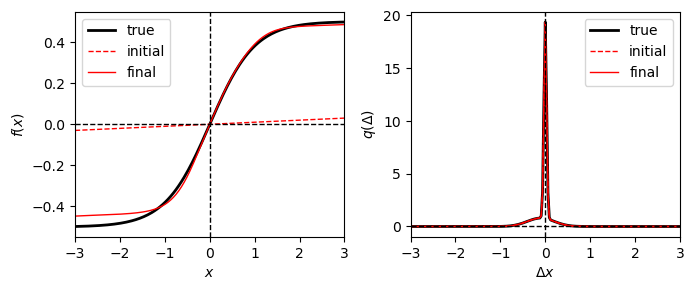

In [90]:
fig, axes = plt.subplots(figsize=(7, 3), nrows=1, ncols=2, )

naive_gauge(params_true[0].map(jnp.exp), zero_idx).plot(axes[0], color="k", lw=2, label="true")
naive_gauge(params0[0].map(jnp.exp), zero_idx).plot(axes[0], color="r", ls="--", lw=1, label="initial")
naive_gauge(params[0].map(jnp.exp), zero_idx).plot(axes[0], color="r", lw=1, label="final")
axes[0].axhline(0, color="k", ls="--", lw=1)
axes[0].axvline(0, color="k", ls="--", lw=1)
axes[0].set_xlim(x_min, x_max)
axes[0].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$f(x)$")
axes[0].legend()

params_true[1].map(jnp.exp).plot(axes[1], color="k", lw=2, label="true")
params0[1].map(jnp.exp).plot(axes[1], color="r", ls="--", lw=1, label="initial")
params[1].map(jnp.exp).plot(axes[1], color="r", lw=1, label="final")
axes[1].axhline(0, color="k", ls="--", lw=1)
axes[1].axvline(0, color="k", ls="--", lw=1)
axes[1].set_xlim(x_min, x_max)
axes[1].set_xlabel(r"$\Delta x$")
axes[1].set_ylabel(r"$q(\Delta )$")
# axes[1].set_yscale("log")
axes[1].legend()

plt.tight_layout()
plt.show()

In [91]:
objective(params, sampling_times, affinity_dists, params0[1].map(jnp.exp), 0.0, 0.0, zero_idx, (None, None))

(Array(0.70155535, dtype=float64),
 (None,
  (Array(False, dtype=bool),
   Array(False, dtype=bool),
   Array(0.1, dtype=float64),
   Array(1., dtype=float64),
   Array(1., dtype=float64))))

In [92]:
loss(params, sampling_times, affinity_dists, zero_idx, (None, None))

(Array(0.70155535, dtype=float64),
 (None,
  (Array(False, dtype=bool),
   Array(False, dtype=bool),
   Array(0.1, dtype=float64),
   Array(1., dtype=float64),
   Array(1., dtype=float64))))

Plot likelihood surface

In [93]:
# grid_n = 20
# # we offset by one to manifes any shape bugs
# αs = np.linspace(0.1, 1., grid_n - 1)
# βs = np.linspace(1., 12.0, grid_n)
# γs = np.linspace(-7., 0, grid_n + 1)

# loss_surface_αβ = jnp.array([[loss((dyn.Sigmoid(x[0], x[-1], n, α_, β_, params_true[0].γ), *params_true[1:]), sampling_times, affinity_dists, zero_idx) for β_ in βs] for α_ in αs])
# loss_surface_αγ = jnp.array([[loss((dyn.Sigmoid(x[0], x[-1], n, α_, params_true[0].β, γ_), *params_true[1:]), sampling_times, affinity_dists, zero_idx) for γ_ in γs] for α_ in αs])
# loss_surface_βγ = jnp.array([[loss((dyn.Sigmoid(x[0], x[-1], n, params_true[0].α, β_, γ_), *params_true[1:]), sampling_times, affinity_dists, zero_idx) for γ_ in γs] for β_ in βs])

In [94]:
# fig, ax = plt.subplots(figsize=(4, 3))
# ax.contour(αs, βs,
#            loss_surface_αβ.T,
#            100,
#            colors="k",
#            linestyles="solid",
#            linewidths=1, alpha=0.5,
#            )
# ax.plot(params_true[0].α, params_true[0].β, "gx", alpha=0.5, ms=10, mew=2, label="true")
# ax.plot(params0[0].α, params0[0].β, "ro", alpha=0.5, ms=10, label="initial", clip_on=False)
# ax.plot(params[0].α, params[0].β, "r+", alpha=0.5, ms=10, mew=2, label="final")
# ax.legend(loc="upper right", fontsize=9)
# ax.set_xlabel(r"$\alpha$")
# ax.set_ylabel(r"$\beta$")
# ax.set_title(r"log-likelihood surface")
# plt.tight_layout()
# plt.show()

# fig, ax = plt.subplots(figsize=(4, 3))
# ax.contour(αs, γs,
#            loss_surface_αγ.T,
#            100,
#            colors="k",
#            linestyles="solid",
#            linewidths=1, alpha=0.5,
#            )
# ax.plot(params_true[0].α, params_true[0].γ, "gx", alpha=0.5, ms=10, mew=2, label="true")
# ax.plot(params0[0].α, params0[0].γ, "ro", alpha=0.5, ms=10, label="initial", clip_on=False)
# ax.plot(params[0].α, params[0].γ, "r+", alpha=0.5, ms=10, mew=2, label="final")
# ax.legend(loc="upper right", fontsize=9)
# ax.set_xlabel(r"$\alpha$")
# ax.set_ylabel(r"$\gamma$")
# ax.set_title(r"log-likelihood surface")
# plt.tight_layout()
# plt.show()

# fig, ax = plt.subplots(figsize=(4, 3))
# ax.contour(βs, γs,
#            loss_surface_βγ.T,
#            100,
#            colors="k",
#            linestyles="solid",
#            linewidths=1, alpha=0.5,
#            )
# ax.plot(params_true[0].β, params_true[0].γ, "gx", alpha=0.5, ms=10, mew=2, label="true")
# ax.plot(params0[0].β, params0[0].γ, "ro", alpha=0.5, ms=10, label="initial", clip_on=False)
# ax.plot(params[0].β, params[0].γ, "r+", alpha=0.5, ms=10, mew=2, label="final")
# ax.legend(loc="upper right", fontsize=9)
# ax.set_xlabel(r"$\beta$")
# ax.set_ylabel(r"$\gamma$")
# ax.set_title(r"log-likelihood surface")
# plt.tight_layout()
# plt.show()

Assess reconstruction accuracy

In [95]:
params

(SpatialDiscretization(x0=-3.0, x_final=3.0, n=201, vals=f64[201]),
 SpatialDiscretization(x0=-3.0, x_final=3.0, n=201, vals=f64[201]),
 Gaussian(
   x0=-3.0,
   x_final=3.0,
   n=201,
   mass=Array(0., dtype=float64),
   mean=Array(0., dtype=float64),
   std=Array(0.01, dtype=float64)
 ),
 Gaussian(
   x0=-3.0,
   x_final=3.0,
   n=201,
   mass=Array(1., dtype=float64),
   mean=Array(0., dtype=float64),
   std=Array(0.02, dtype=float64)
 ),
 Array(3.93720854, dtype=float64))

In [96]:
p_samples_inferred = p_solve(naive_gauge(params[0].map(jnp.exp), zero_idx), params[1].map(jnp.exp), *params[2:], sampling_times).ys

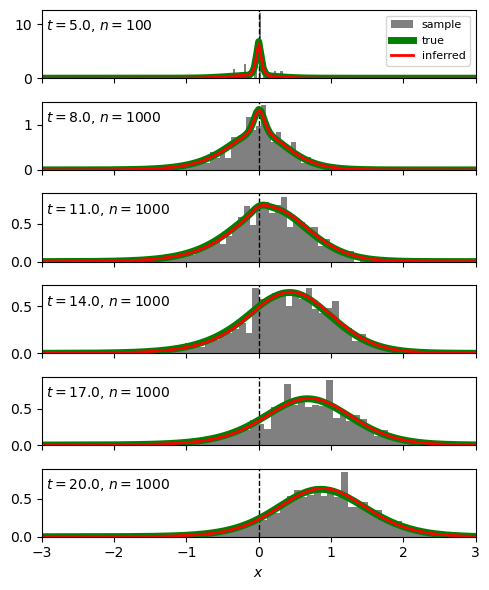

In [97]:
fig, axes = plt.subplots(n_samples, 1, figsize=(5, 6), sharex=True)
for sampling_time, sample_size, sample, p_sample, p_sample_inferred, ax in zip(sampling_times, sample_sizes, samples, p_samples.vals, p_samples_inferred.vals, axes):
    ax.axvline(0, color='k', ls='--', lw=1)
    ax.hist(x[sample], bins=50, density=True, color='grey',
            label="sample" if sampling_time == sampling_times[0] else None)
    ax.plot(x, p_sample, lw=5, color='green',
            label="true" if sampling_time == sampling_times[0] else None)
    ax.plot(x, p_sample_inferred, lw=2, color='r', alpha=1,
    label="inferred" if sampling_time == sampling_times[0] else None)
    ax.annotate(rf"$t={sampling_time}$, $n={sample_size}$", xy=(0.01, 0.7), xycoords="axes fraction")
ax.set_xlabel(r"$x$")
ax.set_xlim(x_min, x_max)
# ax.set_ylim(0, 1)
axes[0].legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()

## Real data

In [98]:
import pandas as pd

df = pd.read_csv("output/10x/data.csv", keep_default_na=False)[["time (days)", "mouse", "delta_bind_CGG", "mutations_H", "mutations_L", "n_mutations_H", "n_mutations_L"]]
df["time (days)"] = df["time (days)"].astype(np.float64)
df.rename(columns={"time (days)": "t", "delta_bind_CGG": "x"}, inplace=True)
assert df.x.isna().sum() == 0
df

,t,mouse,x,mutations_H,mutations_L,n_mutations_H,n_mutations_L
0,14.0,D14M1,0.802294,Y67(H)S,A40(L)G,1,1
1,8.0,D8M1,0.000000,,,0,0
2,8.0,D8M4,0.000000,,,0,0
3,11.0,D11M1,0.803875,,A40(L)G,0,1
4,11.0,D11M1,0.000000,,,0,0
...,...,...,...,...,...,...,...
6905,70.0,D70M5,-2.211060,"K49(H)E,Y52(H)H,Y58(H)F,N68(H)D,T125(H)A","A40(L)G,Y42(L)F,R67(L)K,S92(L)N,E101(L)D",5,5
6906,70.0,D70M6,0.947117,"Q17(H)L,D28(H)A,F45(H)L,S57(H)N,S59(H)N,S64(H)...","A40(L)G,K45(L)R,E101(L)D,L116(L)V,K123(L)N",9,5
6907,70.0,D70M9,3.630998,"D28(H)A,G47(H)E,S57(H)N,S64(H)R,I76(H)F,N92(H)...","Y42(L)F,A52(L)S,A57(L)T,S92(L)N,Q105(L)H,S109(...",7,7
6908,70.0,D70M6,2.346641,"D28(H)V,S57(H)N,A105(H)G,V117(H)I","S7(L)P,Y42(L)F,A52(L)V,D74(L)G,Q105(L)H,N108(L...",4,7


/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_41528/355725015.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recurrent_mutes_df = df.groupby(["t", "mouse"]).apply(lambda x: pd.Series({"A105(H)G fraction": x.mutations_H.str.contains("A105(H)G", regex=False).sum() / len(x), "A40(L)G fraction": x.mutations_L.str.contains("A40(L)G", regex=False).sum() / len(x)})).reset_index()#.rename(columns={0: "A40(L)G fraction"})
/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silen

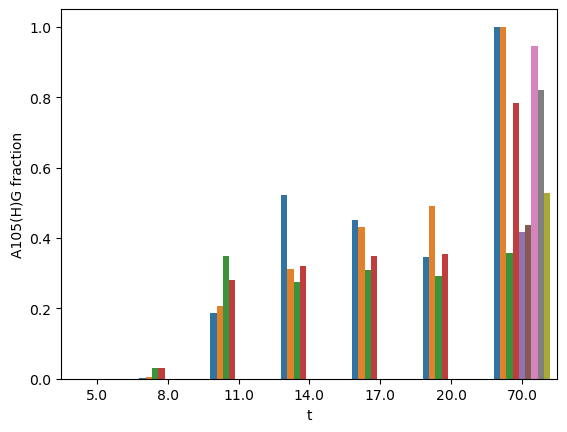

/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key

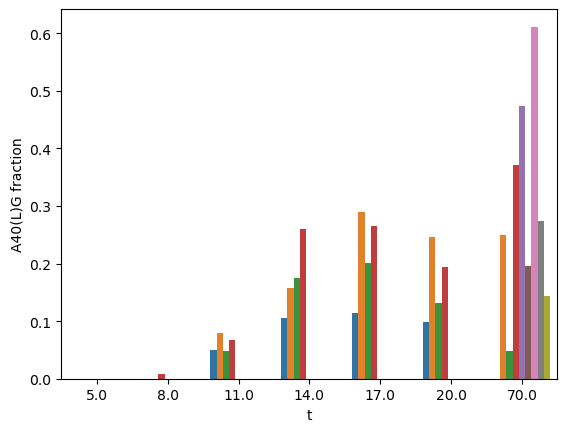

In [99]:
recurrent_mutes_df = df.groupby(["t", "mouse"]).apply(lambda x: pd.Series({"A105(H)G fraction": x.mutations_H.str.contains("A105(H)G", regex=False).sum() / len(x), "A40(L)G fraction": x.mutations_L.str.contains("A40(L)G", regex=False).sum() / len(x)})).reset_index()#.rename(columns={0: "A40(L)G fraction"})

sns.barplot(x=recurrent_mutes_df.t, y=recurrent_mutes_df["A105(H)G fraction"], hue=recurrent_mutes_df.mouse.str.split("M").str[1], legend=False)
plt.show()
sns.barplot(x=recurrent_mutes_df.t, y=recurrent_mutes_df["A40(L)G fraction"], hue=recurrent_mutes_df.mouse.str.split("M").str[1], legend=False)
plt.show()

In [100]:
# Filter 10-week time point
df = df[df.t < 70]

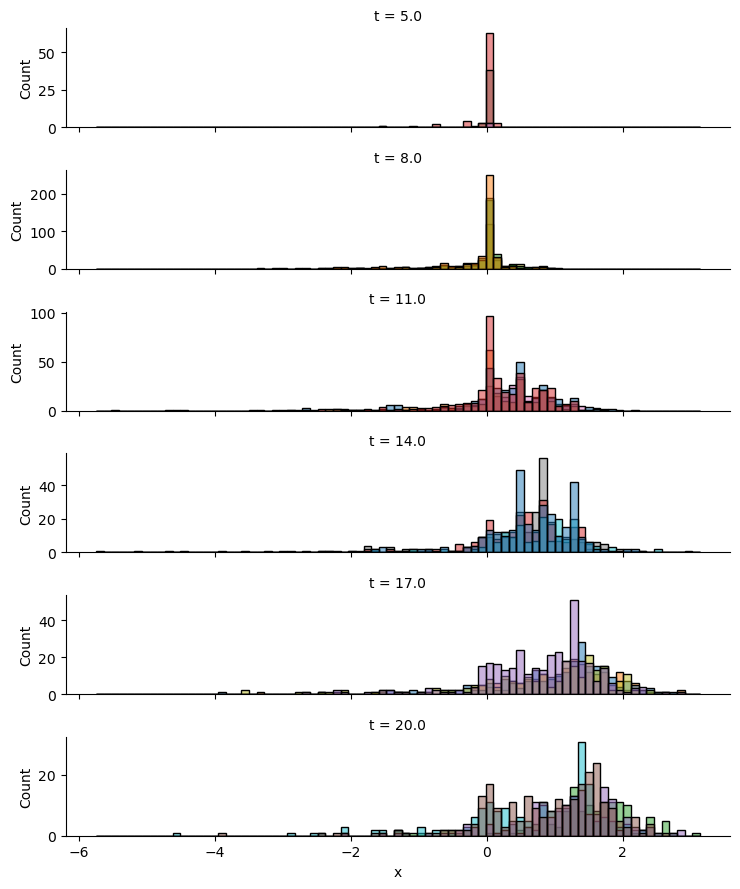

In [101]:
sns.displot(data=df, x="x", row="t", hue="mouse", kind="hist",
            facet_kws={"sharex": True, "sharey": False}, common_norm=False,
            aspect=5, height=1.5, linewidth=1, palette="tab10",
            legend=False)
plt.show()

In [102]:
# Filter extreme affinity values
# df = df.loc[(df.x < x[-1]) & (df.x > x[0])]

In [103]:
df.groupby(["t", "mouse"]).size()

t     mouse
5.0   D5M1       3
      D5M2      43
      D5M3      77
      D5M4       3
8.0   D8M1     477
      D8M2     344
      D8M3     284
      D8M4     394
11.0  D11M1    395
      D11M2    252
      D11M3    252
      D11M4    326
14.0  D14M1    306
      D14M2    248
      D14M3    263
      D14M4    188
17.0  D17M1    350
      D17M2    225
      D17M3    233
      D17M4    203
20.0  D20M1    252
      D20M2    167
      D20M3    206
      D20M4    155
dtype: int64

Wasserstein Barycenters to take the average affinity distribution (across mice) at each time point.

t = 5.0


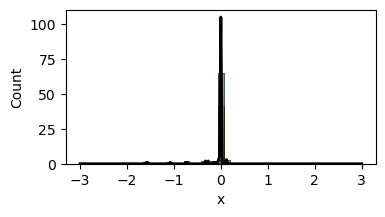

t = 8.0


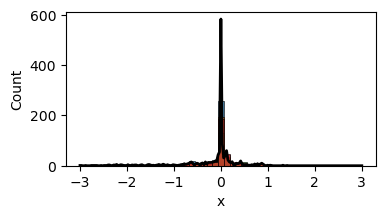

t = 11.0


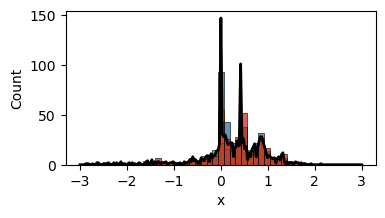

t = 14.0


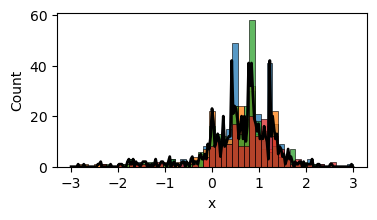

t = 17.0


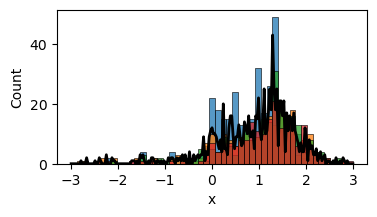

t = 20.0


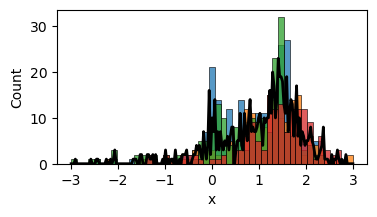

In [228]:
from ott.solvers.linear import discrete_barycenter
from ott.problems.linear import barycenter_problem

ot_solver = jax.jit(discrete_barycenter.FixedBarycenter(max_iterations=200, threshold=.001))

sampling_times = np.sort(df.t.unique())
affinity_bin_counts = np.zeros((len(sampling_times), n))

epsilons = 0.02 * np.ones(6) #np.array([1, 10, 10, 10, 10, 10])

for i, (sampling_time, group) in enumerate(df.groupby("t")):
    print(f"t = {sampling_time}")
    mouse_affinity_bin_counts = np.zeros((len(group.groupby("mouse")), n))
    plt.figure(figsize=(4, 2))
    for j, (mouse, mouse_group) in enumerate(group.groupby("mouse")):
        mouse_affinity_bin_counts[j, :] = np.histogram(mouse_group.x, bins=np.concatenate([x, [x[-1] + x[-1] - x[-2]]]))[0]
        sns.histplot(x=mouse_group.x, bins=np.linspace(-3, 3, 50))

    # geom = ott.geometry.grid.Grid([x], epsilon=epsilons[i])        
    # ot_problem = barycenter_problem.FixedBarycenterProblem(geom, mouse_affinity_bin_counts)
    # # ot_problem = barycenter_problem.FixedBarycenterProblem(geom, mouse_affinity_bin_counts.sum(0, keepdims=True))

    affinity_bin_counts[i, :] = mouse_affinity_bin_counts.sum(0)
    # affinity_bin_counts[i, :] = ot_solver(ot_problem).histogram
    # # affinity_bin_counts[i, :] = scipy.stats.gaussian_kde(group.x, bw_method=.1 * np.sqrt(sampling_time))(x)

    plt.plot(x, affinity_bin_counts[i, :], "k", lw=2)
    plt.show()

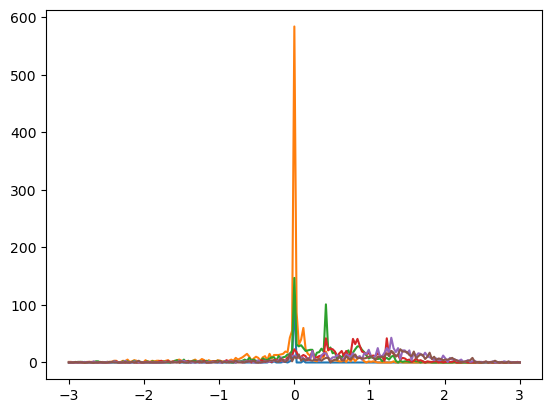

In [229]:
plt.plot(x, affinity_bin_counts.T)
plt.show()

In [230]:
affinity_dists = dyn.SpatialDiscretization(x[0], x[-1], n, affinity_bin_counts)
# affinity_dists /= affinity_dists.integral()[:, None]

In [231]:
affinity_dists.vals.min()

Array(0., dtype=float64)

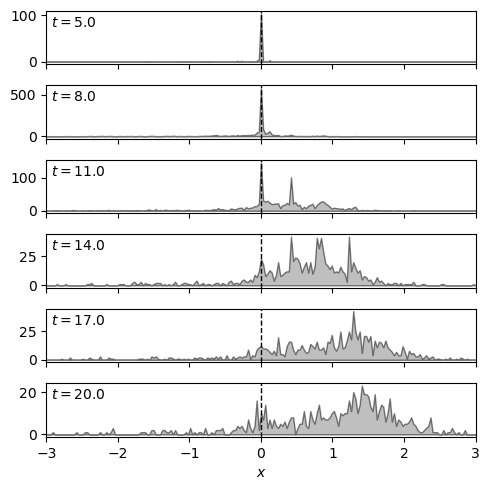

In [232]:
key = jax.random.PRNGKey(0)

fig, axes = plt.subplots(n_samples, 1, figsize=(5, 5), sharex=True)

for sampling_time, dist, ax in zip(sampling_times, affinity_dists.vals, axes):
    ax.axvline(0, color='k', ls='--', lw=1)
    ax.fill_between(x, dist, alpha=0.5, ec="k", fc="grey")
    ax.annotate(rf"$t={sampling_time}$", xy=(0.01, 0.7), xycoords="axes fraction")
ax.set_xlabel(r"$x$")
ax.set_xlim(x_min, x_max)
plt.tight_layout()
plt.show()

**Note:**
- using the S5F 5-mer context model, not the passenger mouse
- Read them from the updated dms scores in a branch in Tyler's repo (new tite-seq fitting)

Read naive sequence from a tree root

In [233]:
results = "../nextflow/results/"

import glob, pickle

def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), int(PR_str[3].lstrip("0"))

files = sorted(glob.glob(f"{results}/gctrees/PR1*/gctree.p"), key=gc_key)

trees = {}
for file in files:
    key = "_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file)))
    assert key not in trees, key
    trees[key] = pickle.load(open(file, "rb"))

naive = next(iter(trees.values())).tree.sequence
igk_idx = 336

In [234]:
mutability = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_mutability.csv", sep=" ", index_col=0).squeeze("columns")
mutability.index.name = "context"
substitution = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_substitution.csv", sep=" ", index_col=0)
substitution.index.name = "context"

padded_igh = "NN" + naive[:igk_idx] + "NN"
padded_igk = "NN" + naive[igk_idx:] + "NN"
# mutabilities of each nucleotide
contexts = [padded_igh[(i - 2) : (i + 3)]
                for i in range(2, len(padded_igh) - 2)
               ] + [padded_igk[(i - 2) : (i + 3)]
                    for i in range(2, len(padded_igk) - 2)
                   ]

# mutation rates at each site in naive
mutation_rates_nt = (mutability[contexts].values[:, None] * substitution.loc[contexts]).reset_index()
mutation_rates_nt[mutation_rates_nt == 0] = np.nan
mutation_rates_nt

,context,A,C,G,T
0,NNGAG,0.000455,0.000042,NaN,0.000059
1,NGAGG,NaN,0.000123,0.000323,0.000061
2,GAGGT,0.000475,0.000060,NaN,0.000044
3,AGGTG,0.001657,0.000247,NaN,0.000274
4,GGTGC,0.000033,0.000057,0.000021,NaN
...,...,...,...,...,...
652,AATAA,0.000157,0.000138,0.000106,NaN
653,ATAAA,NaN,0.000103,0.000507,0.000257
654,TAAAA,NaN,0.000211,0.000895,0.000134
655,AAAAN,NaN,0.000095,0.000466,0.000056


In [235]:
pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
igh_pos_map = pos_df.loc[pos_df.chain == "H", "site"].reset_index(drop=True)
igk_pos_map = pos_df.loc[pos_df.chain == "L", "site"].reset_index(drop=True)

In [236]:
dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/improved-Kd-fitting/tite-seq-modeling/output/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
dms_df.sort_values("delta_bind_CGG", ascending=False)

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG_old,...,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,bind_CGG,delta_bind_CGG
mutation,,,,,,,,,,,,,,,,,,,,,
N108(L)R,CGG_naive,N,219,108,L,CDRL3,R,AAC,False,11.35851,...,10.47079,0.02012,27.0,2.0,6.71015,-0.15045,25.0,2.0,9.532699,0.908006
S64(H)R,CGG_naive,S,56,64,H,CDRH2,R,AGC,True,11.32647,...,10.52073,0.07006,26.0,2.0,7.31574,0.45514,25.0,2.0,9.501983,0.877291
N108(L)K,CGG_naive,N,219,108,L,CDRL3,K,AAC,True,11.32301,...,10.49648,0.04581,53.0,2.0,7.28604,0.42544,49.0,2.0,9.483924,0.859231
D28(H)A,CGG_naive,D,27,28,H,CDRH1,A,GAC,True,11.29198,...,10.51916,0.06849,40.0,2.0,7.06566,0.20507,33.0,2.0,9.483366,0.858673
D28(H)T,CGG_naive,D,27,28,H,CDRH1,T,GAC,False,11.28782,...,10.60297,0.15230,34.0,2.0,7.09466,0.23407,30.0,2.0,9.479409,0.854716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NANA(link)S,CGG_naive,NaN,121,<NA>,link,NaN,S,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NANA(link)T,CGG_naive,NaN,121,<NA>,link,NaN,T,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NANA(link)V,CGG_naive,NaN,121,<NA>,link,NaN,V,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Missing affinities

In [237]:
dms_df.loc[dms_df.delta_bind_CGG.isna() & (dms_df.wildtype != dms_df.mutant) & (dms_df.chain != "link")]

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG_old,...,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,bind_CGG,delta_bind_CGG
mutation,,,,,,,,,,,,,,,,,,,,,
I2(L)F,CGG_naive,I,129,2,L,FWRL1,F,ATT,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
I2(L)L,CGG_naive,I,129,2,L,FWRL1,L,ATT,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S7(L)R,CGG_naive,S,134,7,L,FWRL1,R,TCT,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


affinity effect of stop codon

In [238]:
stop_value = np.nan

In [239]:
from Bio.codonalign.codonseq import CodonSeq

affinity_effect_nt = pd.DataFrame(index=mutation_rates_nt.index, columns=mutation_rates_nt.columns)
affinity_effect_nt.context = mutation_rates_nt.context

codons = CodonSeq(naive)

assert len(contexts) == len(naive) == len(codons)

for codon_idx in range(codons.get_codon_num()):
    codon = CodonSeq(codons.get_codon(codon_idx))
    aa = codon.translate()
    for codon_pos in range(3):
        idx = 3 * codon_idx + codon_pos
        if idx < igk_idx:
            chain = "H"
            imgt_idx = igh_pos_map[idx // 3]
        else:
            chain = "L"
            imgt_idx = igk_pos_map[(idx - igk_idx) // 3]
        assert naive[idx] == codon[codon_pos]
        for alt_nt in "ACGT":
            if alt_nt != naive[idx]:
                mutated_codon = list(codon)
                mutated_codon[codon_pos] = alt_nt
                mutated_codon = CodonSeq("".join(mutated_codon))
                mutated_aa = mutated_codon.translate()
                if mutated_aa == "*":
                    affinity_effect_nt.loc[idx, alt_nt] = stop_value
                elif mutated_aa == aa:
                    affinity_effect_nt.loc[idx, alt_nt] = 0
                else:
                    mutation = f"{aa}{imgt_idx}({chain}){mutated_aa}"
                    affinity_effect_nt.loc[idx, alt_nt] = dms_df.loc[mutation, "delta_bind_CGG"]
affinity_effect_nt

,context,A,C,G,T
0,NNGAG,0.388932,0.205966,NaN,NaN
1,NGAGG,NaN,0.118716,0.199634,0.119531
2,GAGGT,0,0.01155,NaN,0.01155
3,AGGTG,0.001338,0.03571,NaN,0.03571
4,GGTGC,0.038603,-0.082626,0.058043,NaN
...,...,...,...,...,...
652,AATAA,0.061107,0.039716,0.069575,NaN
653,ATAAA,NaN,0,0.101473,0
654,TAAAA,NaN,-0.046096,-0.059505,NaN
655,AAAAN,NaN,0.032604,0.006125,0.018808


In [240]:
assert all(affinity_effect_nt.context == mutation_rates_nt.context)

In [241]:
mismatch_nan_rows = (np.isnan(mutation_rates_nt[list("ACGT")].values.astype("float64")) != np.isnan(affinity_effect_nt[list("ACGT")].values.astype("float64"))).nonzero()[0]

In [242]:
display(mutation_rates_nt.iloc[mismatch_nan_rows, :])
display(affinity_effect_nt.iloc[mismatch_nan_rows, :])

,context,A,C,G,T
0,NNGAG,0.000455,0.000042,NaN,0.000059
6,TGCAG,0.000136,NaN,0.000116,0.001091
12,TTCAG,0.000065,NaN,0.000029,0.000354
15,AGGAG,0.000174,0.000033,NaN,0.000022
19,GTCAG,0.000059,NaN,0.000007,0.000250
...,...,...,...,...,...
617,TATCC,0.000041,0.000072,0.000034,NaN
634,CTCGG,0.000033,NaN,0.000008,0.000332
642,CTAAG,NaN,0.000034,0.000164,0.000083
648,TAGAA,0.001664,0.000289,NaN,0.000128


,context,A,C,G,T
0,NNGAG,0.388932,0.205966,NaN,NaN
6,TGCAG,0.056239,NaN,0.096496,NaN
12,TTCAG,0.098983,NaN,0.008462,NaN
15,AGGAG,0.090356,-0.252667,NaN,NaN
19,GTCAG,NaN,NaN,NaN,-0.017607
...,...,...,...,...,...
617,TATCC,NaN,0,NaN,NaN
634,CTCGG,NaN,NaN,0.035032,0.196227
642,CTAAG,NaN,0.039756,-0.004654,NaN
648,TAGAA,0.076975,0.054759,NaN,NaN


In [243]:
mutation_rates_flat = mutation_rates_nt[list("ACGT")].values.astype("float64").reshape(-1)
affinity_effect_flat = affinity_effect_nt[list("ACGT")].values.astype("float64").reshape(-1)

nan_idxs = np.isnan(mutation_rates_flat) | np.isnan(affinity_effect_flat)

mutation_rates_flat = mutation_rates_flat[~nan_idxs]
mutation_rates_flat /= mutation_rates_flat.sum()

affinity_effect_flat = affinity_effect_flat[~nan_idxs]

**NOTE:** might not be using mutation rates here! uncomment weights in several places to get them back

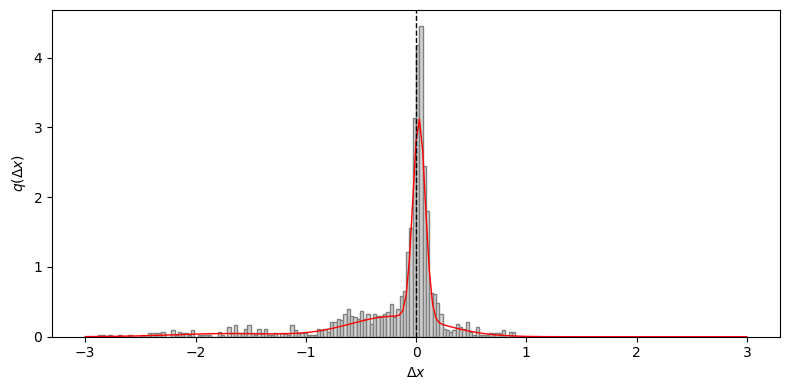

GaussianMixture(
  x0=-3.0,
  x_final=3.0,
  n=201,
  weights=Array([0.5242871 , 0.07500166, 0.40071118], dtype=float64),
  means=Array([ 0.02755218, -1.69909978, -0.18420756], dtype=float64),
  stds=Array([0.05562414, 0.50162599, 0.41373665], dtype=float64)
)

In [244]:
filter_idxs = (affinity_effect_flat != 0) #& (affinity_effect_flat > -3.) & (affinity_effect_flat < 3.)
# filter_idxs = (affinity_effect_flat != 0) & (affinity_effect_flat > -2.0) & (affinity_effect_flat < 2.)
# filter_idxs = (affinity_effect_flat > -3.0) & (affinity_effect_flat < 3.)

gmm = GeneralMixtureModel([Normal(means=[0.0], covs=[0.01**2], covariance_type="diag"),
                           Normal(means=[-.1], covs=[0.1**2], covariance_type="diag"),
                           Normal(means=[.1], covs=[0.1**2], covariance_type="diag"),
                        #    Normal(means=[1.], covs=[0.1**2], covariance_type="diag"),
                            ],
                          tol=1e-10, max_iter=10000,
)

gmm.fit(affinity_effect_flat[filter_idxs, None].astype('float32'),
        # sample_weight=mutation_rates_flat[filter_idxs].astype('float32'),
        )

# kde = scipy.stats.gaussian_kde(affinity_effect_flat[filter_idxs], bw_method=0.1, weights=None)

# q = dyn.SpatialDiscretization(x[0], x[-1], n, jnp.asarray(kde(x)))
q = dyn.GaussianMixture(x[0], x[-1], n,
                        gmm.priors.numpy().astype('float64'),
                        [dist.means.numpy().astype('float64').squeeze() for dist in gmm.distributions],
                        [np.sqrt(dist.covs.numpy().astype('float64').squeeze()) for dist in gmm.distributions]
                        )

# geom = ott.geometry.grid.Grid([x], epsilon=0.01)
# ot_problem = barycenter_problem.FixedBarycenterProblem(geom,
#                                                        np.histogram(affinity_effect_flat[filter_idxs], bins=np.concatenate([x, [x[-1] + x[-1] - x[-2]]]))[0][None, :].astype('float64')
#                                                        )
# q = dyn.SpatialDiscretization(x[0], x[-1], n, ot_solver(ot_problem).histogram.squeeze())

# assert np.allclose(q_norm.integral(), 1.0, atol=1e-3), q_norm.integral()

plt.figure(figsize=(8, 4))
plt.hist(affinity_effect_flat[filter_idxs],
        #  weights=mutation_rates_flat[filter_idxs],
         bins=x, density=True, color='lightgrey', edgecolor='grey')
(filter_idxs.sum() * q / filter_idxs.size / q.integral()).plot(lw=1, color='r')
plt.axvline(0, color='k', ls='--', lw=1)
# plt.xlim(-1.5, 1.5)
plt.ylim(0, None)
plt.xlabel(r"$\Delta x$")
plt.ylabel(r"$q(\Delta x)$")
plt.tight_layout()
plt.show()

q

In [245]:
# note: multiplying by 1.0 casts to a dense field
params0 = (#dyn.Sigmoid(x[0], x[-1], n, 1.2, 1.2, .3).derivative(),
           dyn.SpatialDiscretization(x[0], x[-1], n, .2 * jnp.ones(n)).map(jnp.log),
           (0.5 * q).map(jnp.log),
        #    1.0 * dyn.GaussianMixture(x[0], x[-1], n,
        #                        0.5 * q.weights,
        #                        q.means,
        #                        q.stds
        #                        ),
            dyn.Gaussian(x[0], x[-1], n, 0., .0, 0.4),
            dyn.Gaussian(x[0], x[-1], n, 1., 0., 0.02),
            jnp.array(6.),
            )

# Note: ignoring initial sample timepoint(s), because GCs likely form at 6 to 7 days

In [246]:
lower_bounds = (#dyn.Sigmoid(x[0], x[-1], n, .01, .01, -10.),
                dyn.SpatialDiscretization(x[0], x[-1], n, -jnp.inf * jnp.ones(n)),
                # dyn.GaussianMixture(x[0], x[-1], n,
                #                     jnp.zeros(2),
                #                     -3.0 * jnp.ones(2),
                #                     0.01 * jnp.ones(2)
                #                     ),
                dyn.SpatialDiscretization(x[0], x[-1], n, -jnp.inf * jnp.ones(n)),
                # params0[1],
                dyn.Gaussian(x[0], x[-1], n, 0., -1.0, 0.01),
                dyn.Gaussian(x[0], x[-1], n, 1., 0., 0.02),
                jnp.array(0.0),
                )
upper_bounds = (#dyn.Sigmoid(x[0], x[-1], n, 10., 10., 10.),
                dyn.SpatialDiscretization(x[0], x[-1], n, jnp.inf * jnp.ones(n)),
                # dyn.GaussianMixture(x[0], x[-1], n,
                #                     10 * jnp.ones(2),
                #                     3. * jnp.ones(2),
                #                     2. * jnp.ones(2)
                #                     ),
                # dyn.SpatialDiscretization(x[0], x[-1], n, 10. * jnp.ones(n)),                                    
                # dyn.SpatialDiscretization(x[0], x[-1], n, 1. * jnp.ones(n)),
                params0[1] + 2.,
                dyn.Gaussian(x[0], x[-1], n, 0., 1.0, 1.),
                dyn.Gaussian(x[0], x[-1], n, 1., 0., 0.1),
                .99 * jnp.array(sampling_times[1]),
                )
bounds = (lower_bounds, upper_bounds)

In [247]:
q_ref_norm = params0[1].map(jnp.exp)
q_ref_norm /= q_ref_norm.integral()
# q_ref_norm = dyn.SpatialDiscretization(x[0], x[-1], n, jnp.ones(n))
# q_ref_norm /= q_ref_norm.integral()
q_ref_norm.integral()

Array(1., dtype=float64)

In [273]:
params = params0

opt = jaxopt.ScipyBoundedMinimize(
                    fun=objective,
                    method="l-bfgs-b",
                    jit=True,
                    options=dict(maxcor=1000, maxls=100, iprint=1,
                                #  ftol=0, gtol=0,
                                 ),
                    maxiter=1000,
                    # tol=0,
                    has_aux=True,
                    )

# opt = jaxopt.LBFGSB(
#                     objective,
#                     jit=True,
#                     # implicit_diff=True,
#                     verbose=1,
#                     maxiter=200, tol=1e-10,
#                     # linesearch="backtracking",
#                     maxls=30,
#                     min_stepsize=0.1,
#                     max_stepsize=10.0,
#                     # stepsize=10.0,
#                     history_size=1000,
#                     has_aux=True,
#                     )

# opt = jaxopt.ProjectedGradient(
#                     objective,
#                     jaxopt.projection.projection_box,
#                     jit=True,
#                     verbose=True,
#                     maxiter=100, tol=1e-10,
#                     maxls=30,
#                     # stepsize=.1,
#                     acceleration=False,
#                     has_aux=True,
#                     )

sample_filter = slice(1, len(sampling_times))

affinity_dists_skip = dyn.SpatialDiscretization(x[0], x[-1], n, affinity_dists.vals[sample_filter, :])

aux = (None, None)
reg = (1e-4, 5e-1)
# state = opt.init_state(params, bounds, sampling_times[sample_filter], affinity_dists_skip, q_ref_norm, *reg, zero_idx, aux)
# for _ in range(100):
#     params, state = opt.update(params, state, bounds, sampling_times[sample_filter], affinity_dists_skip, q_ref_norm, *reg, zero_idx, state.aux)
#     print(state.iter_num, state.error, state.stepsize)


params, state = opt.run(params, bounds, sampling_times[sample_filter], affinity_dists_skip, q_ref_norm, *reg, zero_idx, aux)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          409     M =         1000

At X0         4 variables are exactly at the bounds

At iterate    0    f=  1.45462D+00    |proj g|=  1.14726D-01

At iterate    1    f=  1.41216D+00    |proj g|=  1.11381D-01

At iterate    2    f=  1.00609D+00    |proj g|=  6.87612D-02

At iterate    3    f=  1.00342D+00    |proj g|=  1.10181D-01

At iterate    4    f=  1.00291D+00    |proj g|=  6.06157D-02

At iterate    5    f=  1.00216D+00    |proj g|=  4.85469D-02

At iterate    6    f=  1.00146D+00    |proj g|=  6.98002D-02

At iterate    7    f=  9.99716D-01    |proj g|=  8.86611D-02

At iterate    8    f=  9.97902D-01    |proj g|=  1.50485D-01

At iterate    9    f=  9.95928D-01    |proj g|=  1.04236D-01

At iterate   10    f=  9.93804D-01    |proj g|=  1.00537D-01

At iterate   11    f=  9.90612D-01    |proj g|=  1.68645D-01

At iterate   12    f=  9.87255D-01    |proj g|=  2.26756D-01

At iterate   13    f=  9.8

In [274]:
params

(SpatialDiscretization(x0=-3.0, x_final=3.0, n=201, vals=f64[201]),
 SpatialDiscretization(x0=-3.0, x_final=3.0, n=201, vals=f64[201]),
 Gaussian(
   x0=-3.0,
   x_final=3.0,
   n=201,
   mass=Array(0., dtype=float64),
   mean=Array(0., dtype=float64),
   std=Array(0.4, dtype=float64)
 ),
 Gaussian(
   x0=-3.0,
   x_final=3.0,
   n=201,
   mass=Array(1., dtype=float64),
   mean=Array(0., dtype=float64),
   std=Array(0.02, dtype=float64)
 ),
 Array(6.23741023, dtype=float64))

In [275]:
state

ScipyMinimizeInfo(fun_val=Array(0.83998566, dtype=float64, weak_type=True), success=True, status=0, iter_num=851, hess_inv=LbfgsInvHessProduct(sk=[[ 2.74203225e-07  1.96542464e-06  5.08733316e-06 ...  0.00000000e+00
   0.00000000e+00 -1.14725746e-01]
 [ 3.07609317e-06  3.41931071e-05  7.86105948e-05 ...  0.00000000e+00
   0.00000000e+00 -1.81357809e+00]
 [-4.09334721e-06  1.30649303e-05  9.12548244e-06 ...  0.00000000e+00
   0.00000000e+00 -2.16125162e-01]
 ...
 [-8.12218439e-03 -8.08395238e-03 -8.03573966e-03 ...  0.00000000e+00
   0.00000000e+00  2.92790840e-04]
 [-1.20368124e-03 -1.23683871e-03 -1.26821702e-03 ...  0.00000000e+00
   0.00000000e+00  2.66226642e-04]
 [ 1.85654432e-04  1.75544056e-04  1.69333208e-04 ...  0.00000000e+00
   0.00000000e+00  5.84239980e-05]], yk=[[ 5.33392408e-06 -1.31625044e-05  7.80683696e-06 ...  9.95621144e-02
  -1.48551318e-03 -3.34450606e-03]
 [ 4.97295513e-05 -9.57639417e-05  1.00034289e-06 ...  1.68308053e+00
  -6.05411540e-01 -1.05932691e-01]
 [-7

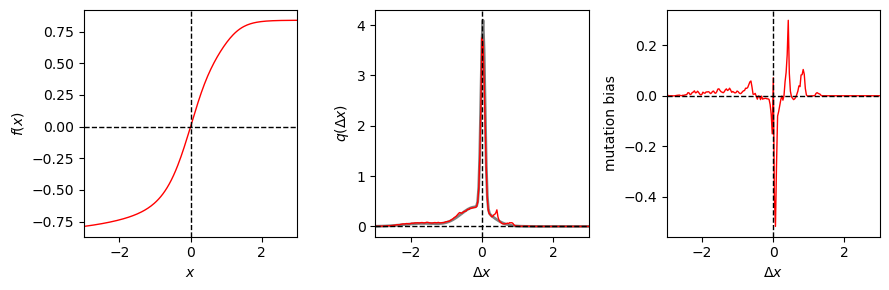

In [284]:
fig, axes = plt.subplots(figsize=(9, 3), nrows=1, ncols=3, )

# naive_gauge(params0[0].map(jnp.exp), zero_idx).plot(axes[0], color="grey", lw=2, label="initial")
naive_gauge(params[0].map(jnp.exp), zero_idx).plot(axes[0], color="r", lw=1, label="fit")
# params0[0].plot(axes[0], color="k", ls=":", lw=1, label="initial")
axes[0].axhline(0, color="k", ls="--", lw=1)
axes[0].axvline(0, color="k", ls="--", lw=1)
axes[0].set_xlim(x_min, x_max)
# axes[0].set_ylim(-params[0].vals.max(), params[0].vals.max())
axes[0].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$f(x)$")
# axes[0].legend()

(params0[1].map(jnp.exp) / params0[1].map(jnp.exp).integral()).plot(axes[1], color="grey", ls="-", lw=2, label="uniform")
(params[1].map(jnp.exp) / params[1].map(jnp.exp).integral()).plot(axes[1], color="r", lw=1, label="mutation bias fit")
axes[1].axhline(0, color="k", ls="--", lw=1)
axes[1].axvline(0, color="k", ls="--", lw=1)
axes[1].set_xlim(x_min, x_max)
axes[1].set_xlabel(r"$\Delta x$")
axes[1].set_ylabel(r"$q(\Delta x)$")
# axes[1].set_yscale("log")
# axes[1].legend()

(params[1].map(jnp.exp) / params[1].map(jnp.exp).integral()).binop((params0[1].map(jnp.exp) / params0[1].map(jnp.exp).integral()), jax.scipy.special.rel_entr).plot(axes[2], color="r", lw=1)
axes[2].axhline(0, color="k", ls="--", lw=1)
axes[2].axvline(0, color="k", ls="--", lw=1)
axes[2].set_xlim(x_min, x_max)
axes[2].set_xlabel(r"$\Delta x$")
axes[2].set_ylabel("mutation bias")
# axes[2].set_yscale("log")

plt.tight_layout()

plt.savefig("output/affinity-fitness-response/parameters.pdf")
plt.show()

/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_41528/919217521.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


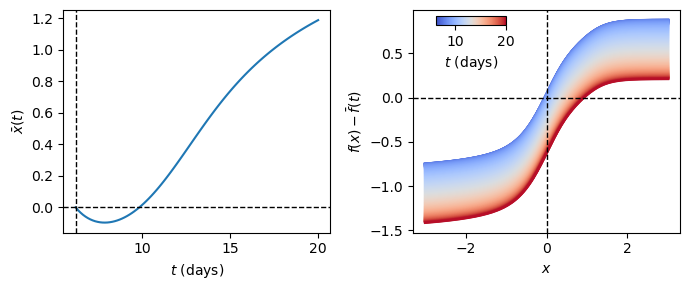

In [285]:
times = np.linspace(params[4], sampling_times[-1], 100)
p_inferred = p_solve(naive_gauge(params[0].map(jnp.exp), zero_idx), params[1].map(jnp.exp), *params[2:], times).ys

x_bar_traj = (p_inferred * x).integral()
f_bar_traj = (p_inferred * naive_gauge(params[0].map(jnp.exp), zero_idx)).integral()

fig, axes = plt.subplots(figsize=(7, 3), nrows=1, ncols=2)

axes[0].plot(times, x_bar_traj)
axes[0].axhline(0, color="k", ls="--", lw=1)
axes[0].axvline(params[4], color="k", ls="--", lw=1)
axes[0].set_xlabel(r"$t$ (days)")
axes[0].set_ylabel(r"$\bar{x}(t)$")

for i, time in enumerate(times):
    (naive_gauge(params[0].map(jnp.exp), zero_idx) - f_bar_traj[i]).plot(axes[1], lw=2, color=plt.cm.coolwarm(i / len(times)), alpha=0.9)
axes[1].axhline(0, color="k", ls="--", lw=1)
axes[1].axvline(0, color="k", ls="--", lw=1)
axes[1].set_xlabel(r"$x$")
axes[1].set_ylabel(r"$f(x) - \bar{f}(t)$")
cbar = plt.colorbar(
             mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=times[0], vmax=times[-1]),
                                   cmap="coolwarm"),
             orientation='horizontal',
             cax=fig.add_axes([.63, 0.9, 0.1, 0.03]),
)
cbar.set_label(label='$t$ (days)', size=10)

plt.tight_layout()

plt.savefig("output/affinity-fitness-response/fitness_trajectory.pdf")
plt.show()

# params[0].plot(axes[0], color="r", lw=1, label="fit")
# # params0[0].plot(axes[0], color="k", ls=":", lw=1, label="initial")
# axes[0].axhline(0, color="k", ls="--", lw=1)
# axes[0].axvline(0, color="k", ls="--", lw=1)
# axes[0].set_xlim(x_min, x_max)
# # axes[0].set_ylim(-params[0].vals.max(), params[0].vals.max())
# axes[0].set_xlabel(r"$x$")
# axes[0].set_ylabel(r"$f(x)$")
# # axes[0].legend()

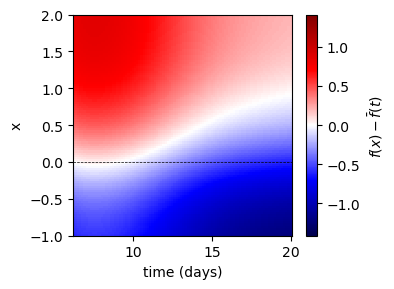

In [286]:
norm = mpl.colors.CenteredNorm(vcenter=0, halfrange=None, clip=False)

fig, ax = plt.subplots(figsize=(4, 3))
dyn.SpatialDiscretization(x[0], x[-1], n, naive_gauge(params[0].map(jnp.exp), zero_idx).vals[None, :] - f_bar_traj[:, None]).plot(ax, times, 
                                                                                                                     cmap="seismic", norm=norm)
ax.axhline(0, color="k", ls="--", lw=0.5)
ax.set_xlabel(r"time (days)")
ax.set_ylabel(r"x")
ax.set_ylim(-1, 2)
plt.colorbar(label=r"$f(x) - \bar{f}(t)$", ax=ax)

plt.tight_layout()
plt.savefig("output/affinity-fitness-response/fitness-heatmap.pdf")
plt.show()


In [287]:
p_samples_inferred = p_solve(naive_gauge(params[0].map(jnp.exp), zero_idx), params[1].map(jnp.exp), *params[2:], sampling_times[1:]).ys

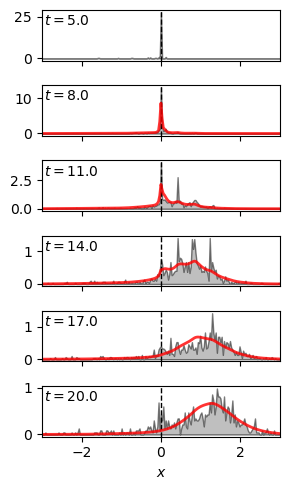

In [288]:
fig, axes = plt.subplots(n_samples, 1, figsize=(3, 5), sharex=True, sharey=False)
axes[0].axvline(0, color='k', ls='--', lw=1)
axes[0].fill_between(x, (affinity_dists / affinity_dists.integral()[:, None]).vals[0], alpha=0.5, ec="k", fc="grey")
axes[0].annotate(rf"$t={sampling_times[0]}$", xy=(0.01, 0.7), xycoords="axes fraction")
for i, (sampling_time, dist_norm, p_sample_inferred, ax) in enumerate(zip(sampling_times[1:], (affinity_dists / affinity_dists.integral()[:, None]).vals[1:], p_samples_inferred.vals, axes[1:])):
    ax.axvline(0, color='k', ls='--', lw=1)
    ax.fill_between(x, dist_norm, alpha=0.5, ec="k", fc="grey")
    ax.plot(x, p_sample_inferred, lw=2, color='r', alpha=0.8)
    ax.annotate(rf"$t={sampling_time}$", xy=(0.01, 0.7), xycoords="axes fraction")
#     ax.set_ylim(0, 1.1 * cts.max())
ax.set_xlabel(r"$x$")
ax.set_xlim(x_min, x_max)
plt.tight_layout()
plt.savefig("output/affinity-fitness-response/fit.pdf")
plt.show()

/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_41528/2563293844.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["fitness"] = scipy.interpolate.interp1d(x, naive_gauge(params0[0].map(jnp.exp), zero_idx).vals, kind="cubic", fill_value="extrapolate")(df.x)
/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_41528/2563293844.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["relative_fitness"] = df.fitness - df.groupby("t").fitness.transform("mean")
/var/folders/0w/l84hyz3n6ns582p

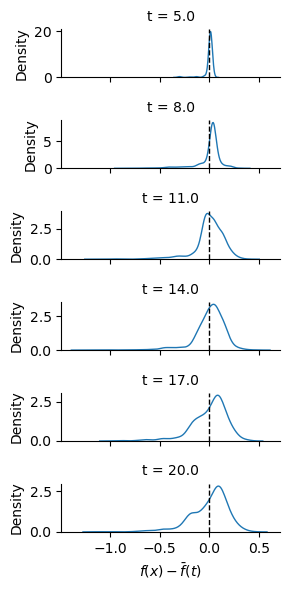

In [289]:
df["fitness"] = scipy.interpolate.interp1d(x, naive_gauge(params0[0].map(jnp.exp), zero_idx).vals, kind="cubic", fill_value="extrapolate")(df.x)
df["relative_fitness"] = df.fitness - df.groupby("t").fitness.transform("mean")

g = sns.displot(data=df, x="relative_fitness", row="t", kind="kde",
            facet_kws={"sharex": True, "sharey": False}, common_norm=False,
            aspect=3, height=1, linewidth=1, palette="tab10",
            legend=False)
plt.xlabel(r"$f(x) - \bar{f}(t)$")

g.axes[0, 0].axvline(0, color="k", ls="--", lw=1)
g.axes[1, 0].axvline(0, color="k", ls="--", lw=1)
g.axes[2, 0].axvline(0, color="k", ls="--", lw=1)
g.axes[3, 0].axvline(0, color="k", ls="--", lw=1)
g.axes[4, 0].axvline(0, color="k", ls="--", lw=1)
g.axes[5, 0].axvline(0, color="k", ls="--", lw=1)

plt.tight_layout()
plt.savefig("output/affinity-fitness-response/relative-fitness.pdf")
plt.show()